In [1]:
import copy

import cv2
from matplotlib import pyplot as plt
from object_data_csv import create_object_df, prepare_object_dict, add_to_csv, create_csv

##################################### Vision Imports ###########################################
import numpy as np
import os
import vision_tools as vt
from vision_tools import normclean2cv2
import kinect_vision as kv
from kinect_vision import PATH_TO_KINECT_IMAGES_DIR
from image_processing import run_calibration, run_calibration_rgb
from image_processing import run_image_processing_v2_depth, run_image_processing_v2_rgb

from tableObject_class import TableObject, match_rgb_with_depth, match_rgb_with_depth_v2
object_ipt_dict = {'cd':      [1,'rgb'],
                   'book':    [2,'rgb'],
                   'eraser':  [3,'rgb'],
                   'measure': [4,'depth'],
                   'box':     [5,'rgb'],
                   'mug':     [6,'depth'],
                   'torch':   [7,'depth'],
                   'tape':    [8,'depth'],
                   'banana':  [9,'depth'],
                   'ball':    [10,'depth']}


##################### Vision Initialise #####################################
directory = PATH_TO_KINECT_IMAGES_DIR

cali = kv.load_npz_as_array("im_array_cal_FINAL", directory)
empt = kv.load_npz_as_array("im_array_empty_FINAL", directory)

empt_all = kv.prepare_im_array(empt)
cali_all = kv.prepare_im_array(cali)

depth_cali = run_calibration(empt_all, cali_all, adjust=False)
rgb_cali = run_calibration_rgb(empt_all, cali_all, depth_cali, adjust=False)

{'radius': [8, 16], 'thresh': [85, 100]}
34
All Calibration points found
{'radius': [5, 8], 'thresh': [85, 220]}
26
All Calibration points found
(174, 199)


In [11]:
while(1):
    capture_check = raw_input("Ready?: ")
    if capture_check == "yes":
        test = kv.capture_frames()
        test_all = kv.prepare_im_array(test)
        break

######## Process Test Image and Retrieve Depth and Contour Information from Depth and RGB Data ##########

rgb, depth, ir = test_all


normclean, sorted_family = run_image_processing_v2_depth(test_all, 
                                                         depth_cali, 
                                                         show=False)

rgbnormclean, rgb_family, test_rgbx_img = run_image_processing_v2_rgb(test_all, 
                                                                      rgb_cali, 
                                                                      depth_cali, 
                                                                      show=False)

######## Clean the images and convert them so that they are cv2 compatible ############

depth_normclean = normclean2cv2(normclean)
rgb_normclean = normclean2cv2(rgbnormclean)

#
test_rgb_img = vt.convert2rgb(test_rgbx_img)

cv2.imwrite("test_rgb_img.jpg", test_rgb_img)

####### Create List of Objects and match the rgb and depth data ##########
# Note that the label here is False which means that depth profiles will be overlaid with their 
# rgb counterparts objects will be labelled based on their spatial distances

obj_list = match_rgb_with_depth_v2(sorted_family, rgb_family, depth_normclean, test_rgb_img, label=False)

object_list = copy.copy(obj_list)

for item in object_list.keys():
    if object_list[item].height[0] == 0:
         #if abs(object_list[item].rgb_area - 3*obj_features_mean.rgb_area.book)/obj_features_std.rgb_area.book > 1:
                        #print "TOO SMALL/BIG TO BE BOOK"
                        #del object_list[item]
                    if object_list[item].name != 'cd':
                        print "TO BE DELETED: ",item
                        del object_list[item]

#cv2.imwrite("test_rgb_img.jpg", test_rgb_img)
cv2.imwrite("depth_normclean.jpg", depth_normclean)

Ready?: yes
[1]
Depth Done
(174, 199)
Making depth List ...
1
RGB data not considered
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'rgb_box'",)
Making rgb object list...
Depth data not implemented
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'box'",)
item
Length of depth and obj lists: 1 1
Matched based on Contour Overlap


True

In [12]:
object_list = copy.copy(obj_list)

In [13]:
import object_recognition_tools as ort

excluded_val = ['centre', 'rgb_centre', 'number of children']
extras = ['R','G','B', 'centre_offset']

obj_features_mean, obj_features_std = ort.prepare_obj_features_param(obj_feat_csv = 'object_features.csv', 
                                                                 excluded_val = excluded_val, 
                                                                 extras=extras)

rec_df = ort.prepare_pick_obj_features_param(object_list, excluded_val, extras)
cost_list = ort.create_cost_list(obj_features_mean, obj_features_std, rec_df)
object_list = ort.label_object_list(object_list, cost_list, test_rgb_img, show=False)
print len(object_list)

for item in object_list.keys():
    if object_list[item].height[0] == 0:
        if object_list[item].name != 'cd':
            print "TO BE DELETED: ",item
            del object_list[item]

pick_obj = object_list.values()[0]

print "==========================================="
print "        OBJECT IS: ", pick_obj.name
print "==========================================="

print "####~~~~~~~~#######~~~~~~~~######"
print [item.name for item in object_list.values()]

ipt = object_ipt_dict[pick_obj.name][0]
if object_ipt_dict[pick_obj.name][1] == 'rgb':
    x_pix = pick_obj.rgb_centre[0]
    y_pix = pick_obj.rgb_centre[1]
else:
    x_pix = pick_obj.centre[0]
    y_pix = pick_obj.centre[1]

print "~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~"
print "Height:       ", pick_obj.height


print "RGB Aspect:   ", pick_obj.rgb_aspect
try:
    print "Circularness: ", pick_obj.circularness
except:
    print "no depth"

circles = depth_cali[4]
cali_circles_init = circles-circles[0][0]
cali_circles=[]
for circ in cali_circles_init[0]:
    cali_circles.append([circ[0]/2, circ[1]/2])
print x_pix, y_pix
print cali_circles

p=[x_pix,y_pix]

plt.figure("Circles")
cv2.circle(test_rgb_img,(int(x_pix),int(y_pix)),3,(0,0,255),1)
cv2.circle(test_rgb_img,(int(x_pix),int(y_pix)),2,(0,0,255),1)
plt.imshow(test_rgb_img)
#plt.show()
cv2.imwrite("test_rgb_img_centre.jpg", test_rgb_img)

1
Index([u'ball', u'mug'], dtype='object', name=u'name')
NAME:  ball
item
1
        OBJECT IS:  ball
####~~~~~~~~#######~~~~~~~~######
['ball']
~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~
Height:        (0.16594863, 0.1703745, 0.42162973, 0.0)
RGB Aspect:    0.820512820513
Circularness:  0.816279966652
97.2728500366 97.9459838867
[[0.0, 0.0], [9.5, 198.5], [174.0, 193.0]]


True

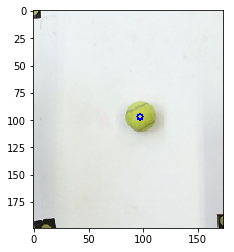

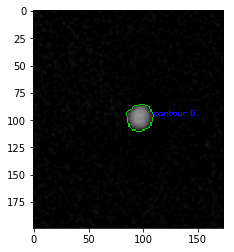

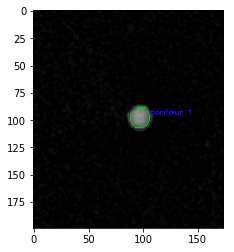

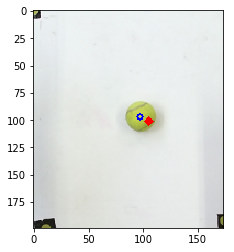

In [14]:
import grasping_points as gp
first_node, node1, node2 = gp.first_grasping_point(pick_obj)
plt.figure()
another_img = cv2.circle(copy.copy(test_rgb_img),
                         (int(first_node[0]),int(first_node[1])),2,(255,0,0),3)
plt.imshow(another_img)
plt.show()

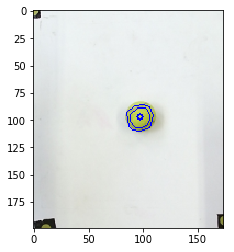

[array([106, 100]), array([104, 104])]


In [21]:
checkcheck=0
for member in pick_obj.nuclear:
    out = cv2.drawContours(test_rgb_img, member['contour'], -1, (0+checkcheck*150,0+checkcheck*255,255+checkcheck*-255), 1)

plt.figure()
plt.imshow(out)
plt.show()

current_line = gp.find_perpendicular_line(node1, node2[0])

possible_pairs = gp.find_possible_cross_pairs(pick_obj, first_node, current_line)
possible_pairs = gp.remove_duplicates(possible_pairs, node1, node2[0])



'''def find_second_grasping_point(possible_pairs, first_node, table_object):
    possible_second_node = []
    for pair in possible_pairs:
        dist, nearest = gp.pnt2line(first_node, pair[0], pair[1])
        possible_second_node.append([p for p in nearest])
    actual_grasp_centre = []
    
    remove_snode = []
    for num_snode, snode in enumerate(possible_second_node):
        node_separation = snode-first_node
        grasp_centre = first_node + node_separation/2
        
        grasp_node1 = first_node - node_separation*0.02
        grasp_node2 = snode + node_separation* 0.02
        grasp_gen = {}
        for gnum, grasp_point in enumerate([grasp_node1, grasp_centre, grasp_node2]):
            grasp_gen[gnum] = gp.find_point_generation(grasp_point, table_object.nuclear)
        
        if grasp_gen[0]!=grasp_gen[2]:
            remove_snode.append(num_snode)
        elif grasp_gen[1]<grasp_gen[0]:
            remove_snode.append(num_snode)
        else:
            actual_grasp_centre.append(grasp_centre)
            plt.figure()
            another_img = cv2.circle(copy.copy(test_rgb_img),
                                 (int(grasp_node1[0]),int(grasp_node1[1])),2,(255,0,0),3)
            another_img = cv2.circle(copy.copy(another_img),
                                 (int(grasp_node2[0]),int(grasp_node2[1])),2,(0,255,0),3)
            another_img = cv2.circle(copy.copy(another_img),
                                 (int(grasp_centre[0]),int(grasp_centre[1])),2,(0,0,255),3)
            plt.imshow(another_img)
            plt.show()
    
    for i in list(reversed(remove_snode)):
        possible_second_node.pop(i)
    
    return possible_second_node, actual_grasp_centre'''


possible_second_node, possible_grasp_centre = gp.find_second_grasping_point(possible_pairs, 
                                                                            first_node, 
                                                                            pick_obj)





second_node, grasp_centre = gp.determine_best_grasping_point(possible_second_node, possible_grasp_centre, first_node)

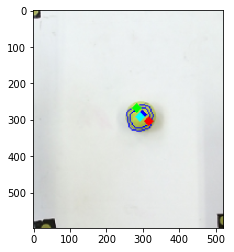

In [23]:
gp.display_grasping_points(test_rgb_img, first_node, second_node, grasp_centre, pick_obj, show=True)